In [46]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [47]:
%matplotlib inline 
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime
import numpy as np
from dmba import regressionSummary

In [48]:
UNIT = '1'
MARKET = 'KRW-BTC'

data_columns = {
    'market': 'Market',
    'candle_date_time_utc': 'Date',
    'opening_price': 'Open',
    'high_price': 'High',
    'low_price': 'Low',
    'trade_price': 'Close',
    'candle_acc_trade_volume': 'Volume',
    'candle_acc_trade_price' : 'Price',
}

# str UTC DATETIME
def get_query_datetime():
    now = datetime.datetime.now() #- datetime.timedelta(hours=9)
    now = str(now.strftime('%Y-%m-%d %H:%M:%S'))
    now = now.replace(' ', 'T') + 'Z'
    return now


# 크롤링한 데이터 전처리
def preprocessing_crawled_data(datas: str):
    array_dict_datas = []
    array_datas = datas.split('},')

    for data in array_datas:
        array_data = []
        data = data.replace('{', '')
        data = data.replace('}', '')
        array_data = data.split(',')

        dict_data = {}
        for value in array_data:
            tmp = value.split(':', 1)
            if tmp[0][1: -1] in data_columns:
                dict_data[data_columns[tmp[0][1: -1]]] = tmp[1]

        dict_data['Market'] = dict_data['Market'][0: -1]
        dict_data['Date'] = dict_data['Date'][1: -1]
        dict_data['Open'] = float(dict_data['Open'])
        dict_data['High'] = float(dict_data['High'])
        dict_data['Low'] = float(dict_data['Low'])
        dict_data['Close'] = float(dict_data['Close'])
        dict_data['Volume'] = float(dict_data['Volume'])
        dict_data['Price'] = float(dict_data['Price'])
        array_dict_datas.append(dict_data)

    return array_dict_datas


# 크롤링 후 df 리턴
def do_crawl(unit: str, market: str, time: str, count: str, loop: int):
    df = pd.DataFrame([], columns=['Date', 'Market', 'Open', 'High', 'Low', 'Close', 'Volume', 'Price'])
    url = "https://api.upbit.com/v1/candles/minutes/" + unit

    for _ in range(loop):
        querystring = {"market": market, "to": time, "count": count}
        response = requests.request("GET", url, params=querystring)
        df = df.append(preprocessing_crawled_data(response.text[1:-1]), ignore_index=True)
        time = df.iloc[-1]['Date'] + 'Z'
    df = df.loc[::-1].reset_index(drop=True)
    return df




# first 데이터 셋 만들기
df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 50)
df.to_csv("test.csv")

print(df)

                     Date    Market        Open        High         Low  \
0     2022-09-21T12:55:00  "KRW-BTC  27135000.0  27143000.0  27125000.0   
1     2022-09-21T12:56:00  "KRW-BTC  27137000.0  27141000.0  27130000.0   
2     2022-09-21T12:57:00  "KRW-BTC  27133000.0  27137000.0  27132000.0   
3     2022-09-21T12:58:00  "KRW-BTC  27132000.0  27135000.0  27114000.0   
4     2022-09-21T12:59:00  "KRW-BTC  27127000.0  27135000.0  27125000.0   
...                   ...       ...         ...         ...         ...   
9995  2022-09-28T11:35:00  "KRW-BTC  27467000.0  27467000.0  27442000.0   
9996  2022-09-28T11:36:00  "KRW-BTC  27456000.0  27456000.0  27391000.0   
9997  2022-09-28T11:37:00  "KRW-BTC  27397000.0  27406000.0  27360000.0   
9998  2022-09-28T11:38:00  "KRW-BTC  27376000.0  27418000.0  27375000.0   
9999  2022-09-28T11:39:00  "KRW-BTC  27409000.0  27409000.0  27398000.0   

           Close    Volume         Price  
0     27142000.0  1.619269  4.393483e+07  
1     2713700

In [49]:
scaler = MinMaxScaler()
# 스케일 적용할 column 정의
scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
# 스케일 후 columns
scaled = scaler.fit_transform(df[scale_cols])

df = pd.DataFrame(scaled, columns=scale_cols)
print(df)

          Open      High       Low     Close    Volume     Price
0     0.323285  0.314892  0.324684  0.325944  0.003763  0.003740
1     0.323978  0.314196  0.326438  0.324212  0.004639  0.004612
2     0.322592  0.312804  0.327139  0.322480  0.001680  0.001670
3     0.322245  0.312109  0.320827  0.320748  0.007930  0.007880
4     0.320513  0.312109  0.324684  0.323519  0.006827  0.006785
...        ...       ...       ...       ...       ...       ...
9995  0.438323  0.427627  0.435835  0.430897  0.005339  0.005369
9996  0.434511  0.423800  0.417952  0.413232  0.007535  0.007568
9997  0.414068  0.406402  0.407083  0.404919  0.009103  0.009131
9998  0.406791  0.410578  0.412342  0.418427  0.006364  0.006383
9999  0.418226  0.407446  0.420407  0.414617  0.000750  0.000753

[10000 rows x 6 columns]


In [50]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('Close', 1), df['Close'], test_size=0.1, random_state=0, shuffle=False)
x_train.shape, y_train.shape
print(type(x_test))
print(x_test)

<class 'pandas.core.frame.DataFrame'>
          Open      High       Low    Volume     Price
9000  0.466389  0.456507  0.463534  0.008903  0.008982
9001  0.457034  0.452331  0.463184  0.008059  0.008127
9002  0.459113  0.448504  0.448457  0.019883  0.020027
9003  0.449064  0.456507  0.448457  0.004755  0.004794
9004  0.467082  0.463814  0.473352  0.002810  0.002837
...        ...       ...       ...       ...       ...
9995  0.438323  0.427627  0.435835  0.005339  0.005369
9996  0.434511  0.423800  0.417952  0.007535  0.007568
9997  0.414068  0.406402  0.407083  0.009103  0.009131
9998  0.406791  0.410578  0.412342  0.006364  0.006383
9999  0.418226  0.407446  0.420407  0.000750  0.000753

[1000 rows x 5 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


In [51]:
def windowed_dataset(x, y, window_size, batch_size, shuffle):
    # X값 window dataset 구성
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(window_size, shift=1, stride=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(window_size))
    # y값 추가
    ds_y = tf.data.Dataset.from_tensor_slices(y[window_size:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [52]:
WINDOW_SIZE=5
BATCH_SIZE=32

In [53]:
train_data = windowed_dataset(x_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(x_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [54]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 5]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

# Sequence 학습에 비교적 좋은 퍼포먼스를 내는 Huber()를 사용
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [55]:
# earlystopping은 35번 epoch통안 val_loss 개선이 없다면 학습을 멈춤
earlystopping = EarlyStopping(monitor='val_loss', patience=35)
# val_loss 기준 체크포인터도 생성
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)
                             
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/1000
    281/Unknown - 5s 9ms/step - loss: 0.0040 - mse: 0.0080
Epoch 1: val_loss improved from inf to 0.00012, saving model to tmp/ckeckpointer.ckpt
282/282 [==============================] - 7s 14ms/step - loss: 0.0040 - mse: 0.0080 - val_loss: 1.1518e-04 - val_mse: 2.3036e-04
Epoch 2/1000
280/282 [============================>.] - ETA: 0s - loss: 1.2176e-04 - mse: 2.4353e-04
Epoch 2: val_loss improved from 0.00012 to 0.00011, saving model to tmp/ckeckpointer.ckpt
282/282 [==============================] - 4s 13ms/step - loss: 1.2194e-04 - mse: 2.4387e-04 - val_loss: 1.0730e-04 - val_mse: 2.1460e-04
Epoch 3/1000
281/282 [============================>.] - ETA: 0s - loss: 1.1909e-04 - mse: 2.3817e-04
Epoch 3: val_loss did not improve from 0.00011
282/282 [==============================] - 4s 14ms/step - loss: 1.1906e-04 - mse: 2.3811e-04 - val_loss: 1.2043e-04 - val_mse: 2.4087e-04
Epoch 4/1000
277/282 [============================>.] - ETA: 0s - loss: 1.0996e-04 - mse: 2.1992e

In [56]:
print("%.7f" % (float(min(history.history['val_loss']))))
model.load_weights(filename)
pred = model.predict(test_data)
actual = np.asarray(y_test)[WINDOW_SIZE:]
actual = np.reshape(actual, (len(actual), 1))
print(pred.shape)
print(actual.shape)

0.0000390
(995, 1)
(995, 1)


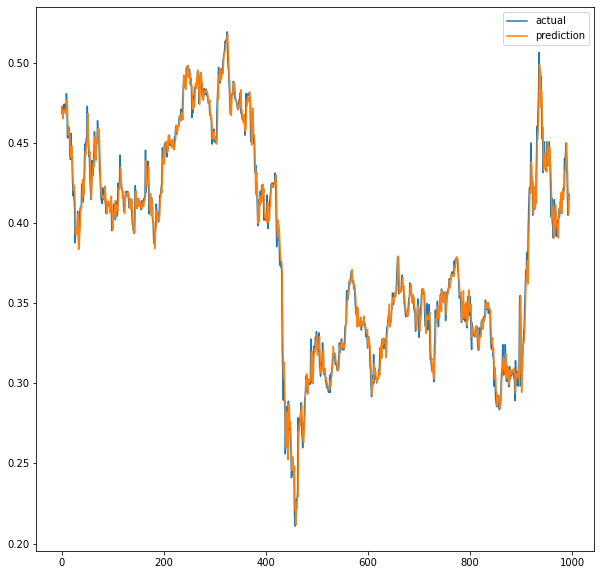

In [57]:
plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [58]:
live_df = do_crawl(UNIT, MARKET, get_query_datetime(), '200', 5)
print(datetime.datetime.now())
print(get_query_datetime())

scale_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'Price']
scaled = scaler.fit_transform(live_df[scale_cols])
live_scaled_df = pd.DataFrame(scaled, columns=scale_cols)
live_x, live_y = live_scaled_df.drop('Close', 1), live_scaled_df['Close']
live_data = windowed_dataset(live_x, live_y, WINDOW_SIZE, BATCH_SIZE, False)

pred = model.predict(live_data)

# create empty table with 12 fields
trainPredict_dataset_like = np.zeros(shape=(len(pred), 6) )
# put the predicted values in the right field
trainPredict_dataset_like[:,0] = pred[:,0]
# inverse transform and then select the right field
pred = scaler.inverse_transform(trainPredict_dataset_like)[:,0]

def muzisung_buy(pred_percent: float, live_percent: float, money: float):
    global array_pred_percents
    array_pred_percents.sort()
    if pred_percent > np.mean(array_pred_percents):
        money = money + (money * live_percent / 100)
    return money

2022-09-28 11:58:22.069906
2022-09-28T11:58:22Z


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


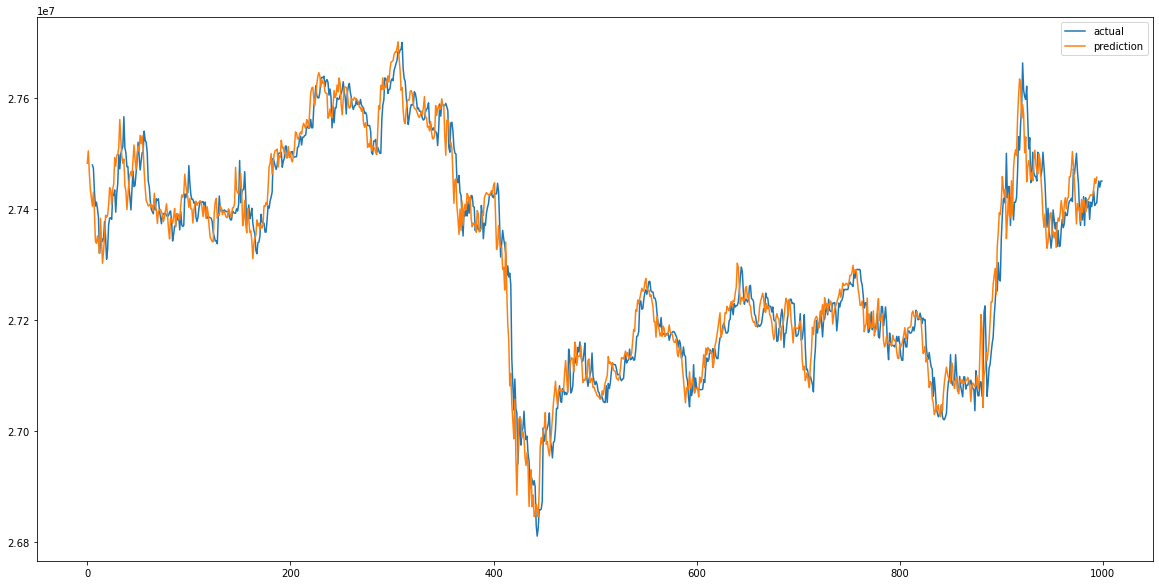

In [59]:
plt.figure(figsize=(20,10))
plt.plot(live_df['Close'][WINDOW_SIZE:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [60]:
regressionSummary(actual, pred)


Regression statistics

                      Mean Error (ME) : -27311256.1275
       Root Mean Squared Error (RMSE) : 27311886.3676
            Mean Absolute Error (MAE) : 27311256.1275
          Mean Percentage Error (MPE) : -7308467542.4798
Mean Absolute Percentage Error (MAPE) : 7308467542.4798
